In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,LogFormatter,StrMethodFormatter,FixedFormatter
import json
import numpy as np
import pandas as pd
import sys
import importlib
import shutil
import math
import os
from pathlib import Path
import warnings

sys.path.append('../utilities')
sys.path.append('../models/grt123')
sys.path.append('../models/grt123/training')
sys.path.append('../models/grt123/preprocessing/')

from layers import nms,iou
from summit_utils import *
from evaluation import noduleCADEvaluation


warnings.simplefilter('ignore')

MIN_THRESHOLD = -10000000

%matplotlib inline

# Data Profiling

The model performance is tightly coupled to the data profile. Below are metadata and nodule profiles for LUNA16 and SUMMIT.

(16187, 26)
(5943, 26)


<Figure size 500x2000 with 0 Axes>

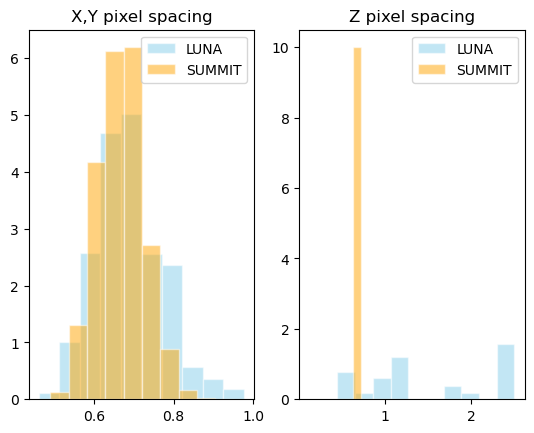

In [2]:
# LUNA metadata
luna_metadata = pd.read_csv('../scans/luna16/metadata/metadata.csv')
luna_metadata[['x_spacing','y_spacing','z_spacing']] = luna_metadata.ElementSpacing.str.strip('[]').str.split(expand=True).astype(float)

lung50_metadata = pd.read_csv('../scans/lung50/lung50_metadata.csv')
lung50_metadata['slices'] = lung50_metadata.slices.astype(float)
lung50_metadata['scan_id'] = lung50_metadata.scan_id.str.strip('.mhd')
lung50_metadata['timepoint'] = lung50_metadata.timepoint.str.strip('.mhd')
veolity_metadata = (
                    pd.read_csv('../scans/lung50/veolity_metadata.csv', usecols=['index','DimSize'])
                    .assign(slices=lambda df: df.DimSize.str.strip('[]').str.split().str[2].astype(float))
                    .assign(scan_id=lambda df: df['index'].str.strip('.mhd').str.split('/').str[-1])
                    .drop(columns=['index','DimSize'])
)

print(lung50_metadata.shape)
lung50_metadata = lung50_metadata.merge(veolity_metadata, left_on=['scan_id','slices'], right_on=['scan_id','slices'])
lung50_metadata = lung50_metadata[lung50_metadata['timepoint']=='Y0_BASELINE_A']
print(lung50_metadata.shape)

fig = plt.figure(figsize=[5,20])
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(luna_metadata.x_spacing, alpha=0.5, color='skyblue', edgecolor='white', label='LUNA', density=True)
ax[0].hist(lung50_metadata['x-spacing'], alpha=0.5, color='orange', edgecolor='white', label='SUMMIT', density=True)
ax[0].set_title('X,Y pixel spacing')
ax[0].legend()

ax[1].hist(luna_metadata.z_spacing, alpha=0.5, color='skyblue', edgecolor='white', label='LUNA', density=True)
ax[1].hist(lung50_metadata['z-spacing'], alpha=0.5, color='orange', edgecolor='white', label='SUMMIT', density=True)
ax[1].set_title('Z pixel spacing')
ax[1].legend()

plt.show()


,1,2,3,4,5,6,7
FPR,0.125,0.25,0.5,1,2,4,8
Liu et al.,0.848,0.876,0.905,0.933,0.943,0.957,0.97
nnDetection,0.812,0.885,0.927,0.95,0.969,0.979,0.985
MONAI-Detection,0.835,0.885,0.931,0.957,0.974,0.983,0.988


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


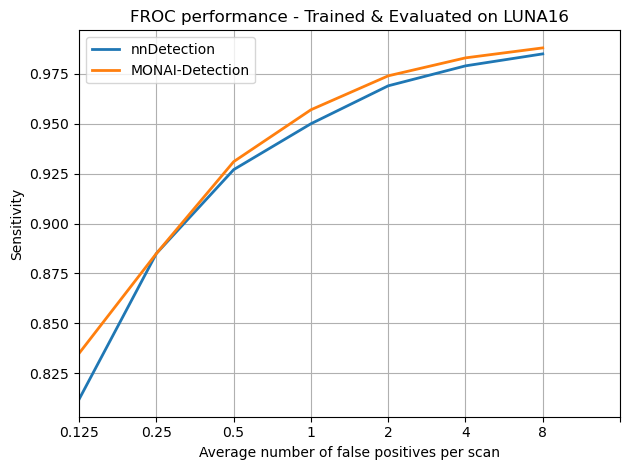

In [3]:
# LUNA16 Results Trained on LUNA16
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = [
    row.split('\t')
    for row in """
    Methods	0.125	0.25	0.5	1	2	4	8
    Liu et al. (2019)	0.848	0.876	0.905	0.933	0.943	0.957	0.970
    nnDetection (2021)	0.812	0.885	0.927	0.950	0.969	0.979	0.985
    MONAI detection	0.835	0.885	0.931	0.957	0.974	0.983	0.988
    """.split('\n')
    if row
]
data = pd.DataFrame(data).transpose().drop(0).drop(4, axis=1).rename(columns={0:'FPR',1:'Liu et al.',2:'nnDetection',3:'MONAI-Detection'})
data[['Liu et al.','nnDetection','MONAI-Detection']] = data[['Liu et al.','nnDetection','MONAI-Detection']].astype(float)

display(data.T)
data.T.to_csv('../output/results/models.csv')

def display_froc(fpr_list, recall_list, labels):


    graphTitle = str("")
    fig1 = plt.figure()
    ax = plt.gca()
    


    xmin = 0.125
    xmax = 8

    plt.xlim(0, 7)
    #plt.ylim(0.8, 1)
    plt.xlabel('Average number of false positives per scan')
    plt.ylabel('Sensitivity')
    plt.legend(loc='lower right')
    plt.title('FROC performance - Trained & Evaluated on LUNA16')
    
    ax.xaxis.set_major_formatter(FixedFormatter([0.125,0.25,0.5,1,2,4,8]))

    for fpr, recall, label in zip(fpr_list, recall_list, labels):
        plt.plot(range(7),fpr , label=label, lw=2)

    # set your ticks manually
    # ax.xaxis.set_ticks(['0.125','0.25','0.5','1','2','4','8'])
    #ax.yaxis.set_ticks(np.arange(0.8, 1.1, 0.1))
    plt.legend()
    plt.grid(visible=True, which='both')
    plt.tight_layout()
    plt.show()



display_froc(
    fpr_list = [
        #np.array(data['Liu et al.']),
        np.array(data['nnDetection']),
        np.array(data['MONAI-Detection'])
        ],
    recall_list=[
        #np.array(data.FPR),
        np.array(data.FPR),
        np.array(data.FPR)
    ],
    labels = [
        #'Liu et al.',
        'nnDetection',
        'MONAI-Detection'
    ])

# GRT123 Evaluation


The evaluation script accepts 4 parameters

1. annotations_filename: csv file with following headers:
    - threshold
    - index
    - row
    - col
    - diameter
    - nodule_type
    - brock_score
    - management_plan
    - ethnic_group

NOTE: Additional nodule fields will need to be added in eval script, fields are hard-coded
into a nodule class

2. annotations_excluded_filename: csv containing non-actionable or benign lesions,
headers as per annotations_filename

3. seriesuids_filename: single column csv file holding just the scan identifiers

4. results_filename: csv containing the candidates generated from the detection algorithm.
Headers as follows:
    - threshold
    - index
    - row
    - col
    - diameter

5. outputdir: folder to output results to


In [4]:
RESULTS_PATH = '../output/results'
METADATA_PATH = '../output/metadata'
BBOX_RESULTS_PATH = '../models/grt123/bbox_result'
MODEL_RESULTS_PATH = '../models/summit_detection/result/'

FROC_minX = 0.125 # Mininum value of x-axis of FROC curve
FROC_maxX = 128 # Maximum value of x-axis of FROC curve

def get_detect_data(model, training_data, run_name, phase, print_summary=True):

    scan_metadata = (
        pd.read_csv(Path(METADATA_PATH, run_name, phase + '_scans_metadata.csv'),
                    usecols=[
                        'LDCT_RADIOLOGY_REPORT_main_participant_id',
                        'participant_details_gender',
                        'participant_age_at_consent_cats',
                        'mpi_ParticipantMetadata_EthnicCategoryStr'
                    ]).rename(columns={
                        'LDCT_RADIOLOGY_REPORT_main_participant_id' : 'participant_id',
                        'participant_details_gender' : 'gender',
                        'participant_age_at_consent_cats' : 'age_group',
                        'mpi_ParticipantMetadata_EthnicCategoryStr' : 'ethnic_group'                    
                    })
        .assign(scan_id=lambda df: df.participant_id + '_Y0_BASELINE_A')
    )

    nodule_metadata = (
        pd.read_csv(Path(METADATA_PATH, run_name, phase + "_metadata.csv"))
        .rename(
        columns={
            'index' : 'nodule_index',
            'nodule_x_coordinate' : 'col',
            'nodule_y_coordinate' : 'row',
            'nodule_z_coordinate' : 'index',
            'LDCT_RADIOLOGY_REPORT_main_participant_id' : 'participant_id',
            'participant_details_gender' : 'gender',
            'participant_age_at_consent_cats' : 'age_group',
            'mpi_ParticipantMetadata_EthnicCategoryStr' : 'ethnic_group'          
        })
        .assign(name=lambda df: df.main_participant_id + '_Y0_BASELINE_A')
        .assign(threshold=MIN_THRESHOLD)
        .assign(diameter=lambda df: df.nodule_diameter_mm)
        .reset_index().rename(columns={'level_0':'id'})
    )

    with open(Path(MODEL_RESULTS_PATH, training_data, run_name, 'result_summit_fold0.json'),'r') as f:
        fold0_json = json.load(f)

    predictions_dict = {}
    idx = 0
    for image in fold0_json['validation']:
        name = image['image'].split('/')[-1].split('.',1)[0]
        
        for box, score in zip(image['box'], image['score']):
            prediction = {}
            prediction['threshold'] = score
            prediction['index'] = box[2]
            prediction['row'] = box[1]
            prediction['col'] = box[0]
            prediction['diameter'] = np.max(box[3:])
            prediction['name'] = name

            predictions_dict[idx] = prediction
            idx+=1

    predictions = pd.DataFrame.from_dict(predictions_dict,orient='index')


    if print_summary:
        print('Prediction:{}, Nodules:{}, Scans:{}'.format(
            predictions.shape[0],
            nodule_metadata.shape[0],
            scan_metadata.shape[0]
        ))

    return scan_metadata, nodule_metadata, predictions

def get_grt123_data(model, training_data, run_name, phase, print_summary=True):
    predictions = pd.read_csv(Path(BBOX_RESULTS_PATH, training_data, run_name, 'predictions.csv'))
    nodule_metadata = pd.read_csv(Path(BBOX_RESULTS_PATH, training_data, run_name, 'metadata.csv'))

    # orrible little hack to include gender and age
    md = pd.read_csv(Path(METADATA_PATH, run_name, phase + '_metadata.csv'),
                     usecols=['participant_id','nodule_lesion_id','gender','age_group'])
    
    nodule_metadata = nodule_metadata.merge(md,
                                left_on=['participant_id','nodule_lesion_id'], 
                                right_on=['participant_id','nodule_lesion_id'])

    scan_metadata = (
        pd.read_csv(Path(METADATA_PATH, run_name, phase + '_scans_metadata.csv'),
                    usecols=[
                        'LDCT_RADIOLOGY_REPORT_main_participant_id',
                        'participant_details_gender',
                        'participant_age_at_consent_cats',
                        'mpi_ParticipantMetadata_EthnicCategoryStr'
                    ]).rename(columns={
                        'LDCT_RADIOLOGY_REPORT_main_participant_id' : 'participant_id',
                        'participant_details_gender' : 'gender',
                        'participant_age_at_consent_cats' : 'age_group',
                        'mpi_ParticipantMetadata_EthnicCategoryStr' : 'ethnic_group'                    
                    })
        .assign(scan_id=lambda df: df.participant_id + '_Y0_BASELINE_A')
    )

    if print_summary:
        print('Prediction:{}, Nodules:{}, Scans:{}'.format(
            predictions.shape[0],
            nodule_metadata.shape[0],
            scan_metadata.shape[0]
        ))

        display(scan_metadata.head())
        display(nodule_metadata.head())
        display(predictions.head())

    return scan_metadata, nodule_metadata, predictions

def create_summary_froc_graph(output_path, limiter, filter_names, filters_fps_itp, filters_sens_itp, x_range=[0.125,0.25,0.5,1,2,4,8,16,32,64,128]):

    graphTitle = str("")
    fig1 = plt.figure()
    ax = plt.gca()
    
    for idx in range(len(filter_names)):
        plt.plot(filters_fps_itp[idx], filters_sens_itp[idx], label="%s" % filter_names[idx], lw=2)

    xmin = FROC_minX
    xmax = FROC_maxX

    plt.xlim(xmin, xmax)
    plt.ylim(0, 1)
    plt.xlabel('Average number of false positives per scan')
    plt.ylabel('Sensitivity')
    plt.legend(loc='lower right')
    plt.title('FROC performance - %s' % (limiter))
    
    plt.xscale('log', base=2)
    ax.xaxis.set_major_formatter(FixedFormatter(x_range))

    # set your ticks manually
    ax.xaxis.set_ticks(x_range)
    ax.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
    plt.grid(visible=True, which='both')
    plt.tight_layout()

    plt.savefig(os.path.join(output_path, "froc_%s.png" % limiter), bbox_inches=0, dpi=300)

def FROCScores(scan_metadata, nodule_metadata, predictions, output_dir, filter_name, min_diameter, management_plan, ethnicity, gender, age, max):
    # RANDOMISATION_AT_YEAR_1

    results_dir = Path(output_dir, 'results')
    results_dir.mkdir(parents=True, exist_ok=True)

    annotations_filepath            = Path(output_dir, 'nodule_annotations.csv')
    annotations_exclude_filepath    = Path(output_dir, 'nodule_exclude_annotations.csv')
    predictions_filepath            = Path(output_dir, 'predictions.csv')
    scanlist_filepath               = Path(output_dir, 'scanslist.csv')

    scan_metadata = scan_metadata[scan_metadata.ethnic_group.isin(ethnicity)]
    scan_metadata = scan_metadata[scan_metadata.gender.isin(gender)]
    scan_metadata = scan_metadata[scan_metadata.age_group.isin(age)]

    nodule_metadata = nodule_metadata[nodule_metadata.ethnic_group.isin(ethnicity)]
    nodule_metadata = nodule_metadata[nodule_metadata.gender.isin(gender)]
    nodule_metadata = nodule_metadata[nodule_metadata.age_group.isin(age)]

    pd.DataFrame(scan_metadata.groupby(['ethnic_group','gender','age_group']).size()).to_csv(Path(results_dir,'scan_counts.csv'))
    pd.DataFrame(nodule_metadata.groupby(['ethnic_group','gender','age_group']).size()).to_csv(Path(results_dir,'nodule_counts.csv'))

    N = max if max < nodule_metadata.shape[0] else nodule_metadata.shape[0]
    nodule_metadata = nodule_metadata.sample(n=N, random_state=42)

    exclude  = (nodule_metadata.management_plan==management_plan) | (nodule_metadata.diameter<min_diameter)
    include_nodule_data = nodule_metadata[~exclude]
    exclude_nodule_data = nodule_metadata[exclude]
    include_nodule_data.to_csv(annotations_filepath, index=False)
    exclude_nodule_data.to_csv(annotations_exclude_filepath, index=False)
    predictions.to_csv(predictions_filepath, index=False)

    with open(scanlist_filepath, 'w') as f:
        for idx, scan_id in enumerate(scan_metadata.scan_id):
            f.write(scan_id)
            f.write('\n')
    print('Unique Scans:', idx)

    fps_itp, sens_itp = noduleCADEvaluation(annotations_filename=annotations_filepath,
                        annotations_excluded_filename=annotations_exclude_filepath,
                        seriesuids_filename=scanlist_filepath,
                        results_filename=predictions_filepath,
                        outputDir=results_dir,
                        filter=filter_name)
    
    return fps_itp, sens_itp

def get_miss_data(output_path, all_nodule_data, exclude_filter=None):
    misses = (
                pd.read_csv(Path(output_path, 'results', 'nodulesWithoutCandidate_predictions.txt'), header=None)
                .rename(columns={
                    0:'name',
                    1:'idx',
                    2:'col',
                    3:'row',
                    4:'index',
                    5:'diameter',
                    6:'candidate_idx'}
                )
    )

    if exclude_filter:
        all_nodule_data = all_nodule_data[all_nodule_data.management_plan!=exclude_filter]

    nodule_data = pd.read_csv(Path(output_path, 'nodule_annotations.csv'))

    return misses.merge(nodule_data, left_on='idx', right_on='id', suffixes=['_miss', ''])

def miss_check(output_path, all_nodule_data, exclude_filter, save=True, show=True):

    misses = get_miss_data(output_path, all_nodule_data, exclude_filter)

    # Check distribution of type vs base distribution to see if one
    tx1 = (pd.concat([
        misses.ethnic_group.value_counts().rename('misses'),
        (misses.ethnic_group.value_counts(normalize=True).rename('misses (%)') * 100).astype(int),
        nodule_data.ethnic_group.value_counts().rename('sample'),
        (nodule_data.ethnic_group.value_counts(normalize=True).rename('sample (%)') * 100).astype(int),
        all_nodule_data.ethnic_group.value_counts().rename('all'),
        (all_nodule_data.ethnic_group.value_counts(normalize=True).rename('all (%)') * 100).astype(int),        
    ], axis=1).fillna(0))
    tx2 = (pd.concat([
        misses.gender.value_counts().rename('misses'),
        (misses.gender.value_counts(normalize=True).rename('misses (%)') * 100).astype(int),
        nodule_data.gender.value_counts().rename('sample'),
        (nodule_data.gender.value_counts(normalize=True).rename('sample (%)') * 100).astype(int),
        all_nodule_data.gender.value_counts().rename('all'),
        (all_nodule_data.gender.value_counts(normalize=True).rename('all (%)') * 100).astype(int),
    ], axis=1).fillna(0))
    tx3 = (pd.concat([
        misses.age_group.value_counts().rename('misses'),
        (misses.age_group.value_counts(normalize=True).rename('misses (%)') * 100).astype(int),
        nodule_data.age_group.value_counts().rename('sample'),
        (nodule_data.age_group.value_counts(normalize=True).rename('sample (%)') * 100).astype(int),
        all_nodule_data.age_group.value_counts().rename('all'),
        (all_nodule_data.age_group.value_counts(normalize=True).rename('all (%)') * 100).astype(int),
    ], axis=1).fillna(0))

    tx123 = pd.concat([tx1,tx2,tx3])

    # type of nodule is being missed
    t1 = (pd.concat([
        misses.nodule_type.value_counts().rename('misses'),
        (misses.nodule_type.value_counts(normalize=True).rename('misses (%)') * 100).astype(int),
        nodule_data.nodule_type.value_counts().rename('sample'),
        (nodule_data.nodule_type.value_counts(normalize=True).rename('sample (%)') * 100).astype(int),
        all_nodule_data.nodule_type.value_counts().rename('all'),
        (all_nodule_data.nodule_type.value_counts(normalize=True).rename('all (%)') * 100).astype(int),
    ], axis=1).fillna(0))

    t2 = (pd.concat([
        misses.management_plan.value_counts().rename('misses'),
        (misses.management_plan.value_counts(normalize=True).rename('misses (%)') * 100).astype(int),
        nodule_data.management_plan.value_counts().rename('sample'),
        (nodule_data.management_plan.value_counts(normalize=True).rename('sample (%)') * 100).astype(int),
        all_nodule_data.management_plan.value_counts().rename('all'),
        (all_nodule_data.management_plan.value_counts(normalize=True).rename('all (%)') * 100).astype(int),
    ], axis=1).fillna(0))

    t3 = (pd.concat([
        misses.nodule_site.value_counts(dropna=False).rename('misses'),
        (misses.nodule_site.value_counts(normalize=True, dropna=False).rename('misses (%)') * 100).astype(int),
        nodule_data.nodule_site.value_counts(dropna=False).rename('sample'),
        (nodule_data.nodule_site.value_counts(normalize=True, dropna=False).rename('sample (%)') * 100).astype(int),
        all_nodule_data.nodule_site.value_counts(dropna=False).rename('all'),
        (all_nodule_data.nodule_site.value_counts(normalize=True, dropna=False).rename('all (%)') * 100).astype(int),
    ], axis=1).fillna(0))

    t123 = pd.concat([t1,t2,t3])

    t4 = (pd.concat([
        misses.diameter.describe().rename('misses (%)'),
        nodule_data.nodule_diameter_mm.describe().rename('sample (%)'),
        all_nodule_data.nodule_diameter_mm.describe().rename('all (%)')
    ], axis=1))

    tables_path = Path(output_path, 'tables')
    tables_path.mkdir(parents=True, exist_ok=True)

    if save:
        tx123.to_csv(Path(tables_path, 'demographic_profile.csv'))
        t123.to_csv(Path(tables_path, 'nodule_profile_1.csv'))
        t4.to_csv(Path(tables_path, 'nodule_profile_2.csv'))

    if show:
        display('Missed nodule profiles')
        display(tx123)
        display(t123)
        display(t4)

    return tx123, t123, t4

def display_toplevel_metrics(scan_metadata, nodule_metadata, predictions, model, training_data, run_name, phase):

    filter_names = []
    filters_fps_itp = []
    filters_sens_itp = []

    for management_plan in ['', 'RANDOMISATION_AT_YEAR_1']:

        filter_name = 'filterNone_excl'+management_plan
        filter_names.append(filter_name)

        output_dir = Path(RESULTS_PATH, model, training_data, run_name, filter_name)
        output_dir.mkdir(parents=True, exist_ok=True)

        fps_itp, sens_itp = FROCScores(scan_metadata,
            nodule_metadata,
            predictions,
            output_dir,
            filter_name,
            0,
            management_plan,
            ['White', 'Asian or Asian British', 'Black', 'Other ethnic groups', 'Mixed'],
            ['MALE','FEMALE'],
            ['55-59', '60-64', '65-69', '70-75', '75+'],
            10000)
        
        _, _, _ = miss_check(output_dir, nodule_metadata, management_plan)
        
        filters_fps_itp.append(fps_itp)
        filters_sens_itp.append(sens_itp)


    create_summary_froc_graph(
        Path(RESULTS_PATH, model, training_data, run_name),
        None,
        filter_names,
        filters_fps_itp,
        filters_sens_itp
    )

def display_granular_metrics(scan_metadata, nodule_metadata, predictions, filters, model, training_data, run_name, phase):

    for management_plan in ['','RANDOMISATION_AT_YEAR_1']:
        for min_nodule_diameter in [0]:
            for filter_group_name, filter_group in filters.items():
                filters_fps_itp = []
                filters_sens_itp = []

                for filter_key, filter_settings in filter_group.items():

                    filter_name = filter_key+f'_excl{management_plan}_min{min_nodule_diameter}'
                    output_dir = Path(RESULTS_PATH, model, training_data, run_name, filter_name)
                    output_dir.mkdir(parents=True, exist_ok=True)
                    fps_itp, sens_itp = FROCScores(scan_metadata,
                            nodule_metadata,
                            predictions,
                            output_dir,
                            filter_name+f'_excl{management_plan}_min{min_nodule_diameter}',
                            min_nodule_diameter,
                            management_plan,
                            filter_settings['ethnicity'],
                            filter_settings['gender'],
                            filter_settings['age'],
                            10000)
                    
                    filters_fps_itp.append(fps_itp)
                    filters_sens_itp.append(sens_itp)

                    _, _, _ = miss_check(output_dir, nodule_metadata, management_plan)                

                create_summary_froc_graph(
                    output_path=Path(RESULTS_PATH, model, training_data, run_name),
                    limiter=f'_grp_{filter_group_name}_excl{management_plan}_min_{min_nodule_diameter}',
                    filter_names=list(filter_group.keys()),
                    filters_fps_itp=filters_fps_itp,
                    filters_sens_itp=filters_sens_itp)
    


## Filters for runs

In [5]:
# Filters 
filters = {
    'ethnicity' : 
    {
        'filter_WHITE' : {
            'ethnicity' : ['White'],
            'gender' : ['MALE','FEMALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        },
        'filter_ASIAN' : {
            'ethnicity' : ['Asian or Asian British'],
            'gender' : ['MALE','FEMALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        },
        'filter_BLACK' : {
            'ethnicity' : ['Black'],
            'gender' : ['MALE','FEMALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        }
    },
    'gender' : 
    {
        'filter_MALE' : {
            'ethnicity' : ['White', 'Asian or Asian British', 'Black', 'Other ethnic groups', 'Mixed'],
            'gender' : ['MALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        },
        'filter_FEMALE' : {
            'ethnicity' : ['White', 'Asian or Asian British', 'Black', 'Other ethnic groups', 'Mixed'],
            'gender' : ['FEMALE'],
            'age' : ['55-59', '60-64', '65-69', '70-75', '75+']
        }
    }
}

## Trained on LUNA16 Evaluted on SUMMIT

Prediction:7445, Nodules:2866, Scans:1783


,participant_id,gender,age_group,ethnic_group,scan_id
0,summit-2224-gak,MALE,65-69,Black,summit-2224-gak_Y0_BASELINE_A
1,summit-2224-jcz,FEMALE,55-59,Black,summit-2224-jcz_Y0_BASELINE_A
2,summit-2224-jgv,FEMALE,65-69,Asian or Asian British,summit-2224-jgv_Y0_BASELINE_A
3,summit-2225-fhj,FEMALE,70-75,White,summit-2225-fhj_Y0_BASELINE_A
4,summit-2225-stn,MALE,60-64,White,summit-2225-stn_Y0_BASELINE_A


,id,main_form_instance_id,main_form_instance_status,main_participant_id,main_created_time,form_instance_status,participant_id,index,nodule_brock_score,nodule_category,...,nodule_z_coordinate,ethnic_group,management_plan,row,col,diameter,threshold,name,gender,age_group
0,0,HEyOYngm6eijK79eBTh_MJX_82J8UfPWA4c2GFdj7Gg,COMPLETED,summit-2224-jcz,2019-08-28 06:25:21,COMPLETED,summit-2224-jcz,185.820007,0.37,BASELINE,...,-131.43,Black,RANDOMISATION_AT_YEAR_1,66.520000,218.280000,2.045311,-10000000,summit-2224-jcz_Y0_BASELINE_A,FEMALE,55-59
1,1,HEyOYngm6eijK79eBTh_MJX_82J8UfPWA4c2GFdj7Gg,COMPLETED,summit-2224-jcz,2019-08-28 06:25:21,COMPLETED,summit-2224-jcz,147.559998,0.70,BASELINE,...,-169.69,Black,RANDOMISATION_AT_YEAR_1,28.340000,63.199993,2.767185,-10000000,summit-2224-jcz_Y0_BASELINE_A,FEMALE,55-59
2,2,4QpjIEdmtpUb9M0W8DPZhheCQCbiuM4WQAbvek4CHxw,COMPLETED,summit-2225-fhj,2020-03-05 08:49:58,COMPLETED,summit-2225-fhj,227.410004,3.05,BASELINE,...,-59.34,White,RANDOMISATION_AT_YEAR_1,130.220000,222.690000,3.375000,-10000000,summit-2225-fhj_Y0_BASELINE_A,FEMALE,70-75
3,3,9_eSXPkX9ppnTmB7isJGKJ2t0TS6iNJRFJt7Hfao__s,COMPLETED,summit-2225-stn,2019-10-16 05:42:43,COMPLETED,summit-2225-stn,155.820007,0.00,BASELINE,...,-178.43,White,RANDOMISATION_AT_YEAR_1,127.779990,212.140000,4.038865,-10000000,summit-2225-stn_Y0_BASELINE_A,MALE,60-64
4,4,9_eSXPkX9ppnTmB7isJGKJ2t0TS6iNJRFJt7Hfao__s,COMPLETED,summit-2225-stn,2019-10-16 05:42:43,COMPLETED,summit-2225-stn,147.839996,0.00,BASELINE,...,-186.41,White,RANDOMISATION_AT_YEAR_1,52.729996,72.840000,2.449803,-10000000,summit-2225-stn_Y0_BASELINE_A,MALE,60-64


,threshold,index,row,col,diameter,name
0,-0.370926,61.600450,45.230392,73.265724,9.103833,summit-2224-gak_Y0_BASELINE_A
1,-0.995496,65.643550,77.150085,81.650580,9.781627,summit-2224-gak_Y0_BASELINE_A
2,-0.120166,37.197820,117.504680,21.492664,8.887494,summit-2224-jcz_Y0_BASELINE_A
3,2.502366,257.792450,101.902140,165.922300,9.524376,summit-2224-jgv_Y0_BASELINE_A
4,-0.673333,21.483385,41.150400,48.953083,8.540439,summit-2224-jgv_Y0_BASELINE_A


Unique Scans: 1753
../output/results/grt123/trained_luna/all/filterNone_excl/nodule_annotations.csv
Total number of included nodule annotations: 2832
Total number of nodule annotations: 2832
Cases: 1754


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,1498,77,2264,78,2264,78
Asian or Asian British,224,11,299,10,299,10
Black,124,6,172,6,172,6
Other ethnic groups,54,2,74,2,74,2
Mixed,39,2,57,1,57,1
MALE,1136,58,1696,59,1696,59
FEMALE,803,41,1170,40,1170,40
65-69,542,27,818,28,818,28
70-75,479,24,723,25,723,25
60-64,461,23,664,23,664,23


,misses,misses (%),sample,sample (%),all,all (%)
PERIFISSURAL,905,46,1211,42,1211,42
SOLID,763,39,1200,41,1200,41
CALCIFIED,112,5,179,6,179,6
NON_SOLID,95,4,145,5,145,5
PART_SOLID,45,2,107,3,107,3
ENDOBRONCHIAL,19,0,24,0,24,0
RANDOMISATION_AT_YEAR_1,1574,81,2004,69,2004,69
3_MONTH_FOLLOW_UP_SCAN,273,14,661,23,661,23
ALWAYS_SCAN_AT_YEAR_1,84,4,134,4,134,4
URGENT_REFERRAL,8,0,67,2,67,2


,misses (%),sample (%),all (%)
count,1939.000000,2866.000000,2866.000000
mean,3.919797,7.174110,7.174110
std,2.501985,4.579834,4.579834
min,0.000000,0.000000,0.000000
25%,2.653516,4.500000,4.500000
50%,3.369140,6.000000,6.000000
75%,4.374806,8.200000,8.200000
max,29.139242,41.100000,41.100000


Unique Scans: 1753
../output/results/grt123/trained_luna/all/filterNone_exclRANDOMISATION_AT_YEAR_1/nodule_annotations.csv
Total number of included nodule annotations: 847
Total number of nodule annotations: 2832
Cases: 1754


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,297,81,710,82,710,82
Asian or Asian British,35,9,73,8,73,8
Black,17,4,40,4,40,4
Other ethnic groups,9,2,17,1,17,1
Mixed,7,1,22,2,22,2
MALE,190,52,454,52,454,52
FEMALE,175,47,408,47,408,47
65-69,108,29,254,29,254,29
70-75,88,24,229,26,229,26
60-64,85,23,188,21,188,21


,misses,misses (%),sample,sample (%),all,all (%)
CALCIFIED,112,30,179,20,179,20
SOLID,105,28,418,48,418,48
NON_SOLID,84,23,134,15,134,15
PART_SOLID,45,12,107,12,107,12
ENDOBRONCHIAL,19,5,24,2,24,2
3_MONTH_FOLLOW_UP_SCAN,273,74,661,76,661,76
ALWAYS_SCAN_AT_YEAR_1,84,23,134,15,134,15
URGENT_REFERRAL,8,2,67,7,67,7
RIGHT_UPPER_LOBE,119,32,280,32,280,32
LEFT_UPPER_LOBE,86,23,173,20,173,20


,misses (%),sample (%),all (%)
count,365.000000,862.000000,862.000000
mean,6.419174,11.030278,11.030278
std,4.428936,6.261209,6.261209
min,0.000000,0.000000,0.000000
25%,3.951955,7.400000,7.400000
50%,5.242385,9.050000,9.050000
75%,7.846099,13.100000,13.100000
max,29.139242,41.100000,41.100000


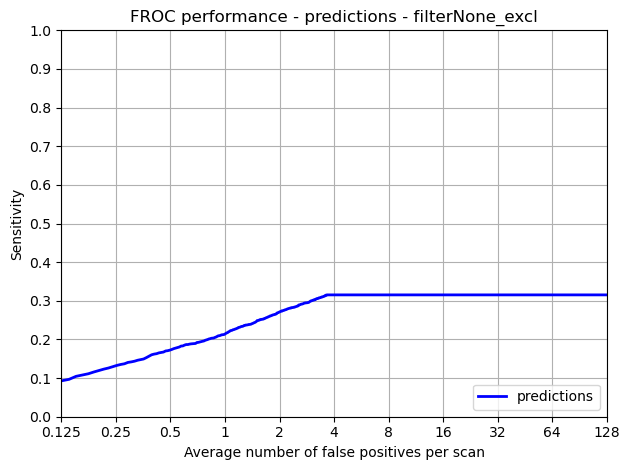

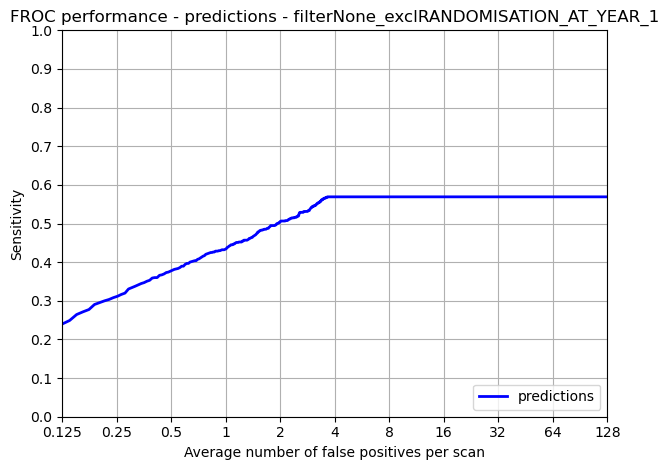

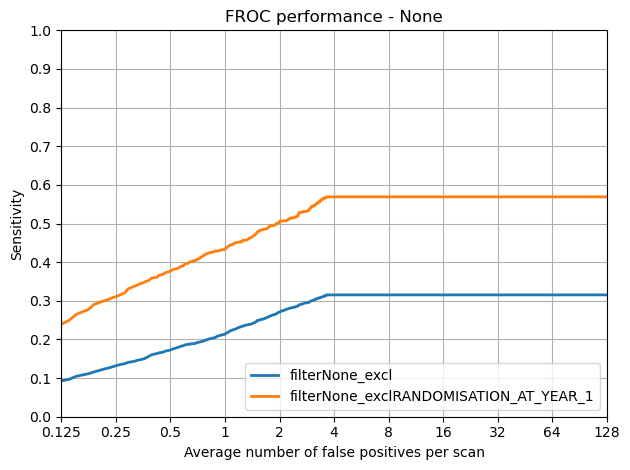

In [6]:
# Get the metadata that will be used across the all runs
config = {
    'model' : 'grt123',
    'run_name' : 'all',
    'training_data' : 'trained_luna',
    'phase' : 'validation'
}
scan_metadata, nodule_metadata, predictions = get_grt123_data(**config)
display_toplevel_metrics(scan_metadata, nodule_metadata, predictions, **config)

## Trained on SUMMIT Evaluated on SUMMIT

Prediction:91773, Nodules:2866, Scans:1783


,participant_id,gender,age_group,ethnic_group,scan_id
0,summit-2224-gak,MALE,65-69,Black,summit-2224-gak_Y0_BASELINE_A
1,summit-2224-jcz,FEMALE,55-59,Black,summit-2224-jcz_Y0_BASELINE_A
2,summit-2224-jgv,FEMALE,65-69,Asian or Asian British,summit-2224-jgv_Y0_BASELINE_A
3,summit-2225-fhj,FEMALE,70-75,White,summit-2225-fhj_Y0_BASELINE_A
4,summit-2225-stn,MALE,60-64,White,summit-2225-stn_Y0_BASELINE_A


,id,main_form_instance_id,main_form_instance_status,main_participant_id,main_created_time,form_instance_status,participant_id,index,nodule_brock_score,nodule_category,...,nodule_z_coordinate,ethnic_group,management_plan,row,col,diameter,threshold,name,gender,age_group
0,12,0ZKAM3Jz5_W9hwXTjmG3SkPSwrFwvn5OJjSSm6P7hR4,COMPLETED,summit-2255-hey,2019-08-31 08:40:57,COMPLETED,summit-2255-hey,42.884998,0.0,BASELINE,...,-227.74,White,RANDOMISATION_AT_YEAR_1,170.410004,46.730003,5.381250,-10000000,summit-2255-hey_Y0_BASELINE_A,FEMALE,60-64
1,13,0ZKAM3Jz5_W9hwXTjmG3SkPSwrFwvn5OJjSSm6P7hR4,COMPLETED,summit-2255-hey,2019-08-31 08:40:57,COMPLETED,summit-2255-hey,57.275002,0.0,BASELINE,...,-213.35,White,RANDOMISATION_AT_YEAR_1,99.469994,69.420006,5.250000,-10000000,summit-2255-hey_Y0_BASELINE_A,FEMALE,60-64
2,14,OknVl3ECnss67Ucy3LjGUNMxIwtJGthc8_TAdrlLmNk,COMPLETED,summit-2262-tta,2019-09-28 14:40:44,COMPLETED,summit-2262-tta,145.649994,0.0,BASELINE,...,-158.10,White,RANDOMISATION_AT_YEAR_1,73.800003,54.040001,2.756250,-10000000,summit-2262-tta_Y0_BASELINE_A,MALE,55-59
3,15,OknVl3ECnss67Ucy3LjGUNMxIwtJGthc8_TAdrlLmNk,COMPLETED,summit-2262-tta,2019-09-28 14:40:44,COMPLETED,summit-2262-tta,126.120003,0.0,BASELINE,...,-177.63,White,RANDOMISATION_AT_YEAR_1,197.729996,125.589996,3.346875,-10000000,summit-2262-tta_Y0_BASELINE_A,MALE,55-59
4,16,OknVl3ECnss67Ucy3LjGUNMxIwtJGthc8_TAdrlLmNk,COMPLETED,summit-2262-tta,2019-09-28 14:40:44,COMPLETED,summit-2262-tta,210.020004,0.0,BASELINE,...,-93.73,White,RANDOMISATION_AT_YEAR_1,176.869995,214.119995,2.690625,-10000000,summit-2262-tta_Y0_BASELINE_A,MALE,55-59


,threshold,index,row,col,diameter,name
0,4.108519,245.731310,126.157840,237.90672,7.033106,summit-2244-pej_Y0_BASELINE_A
1,4.046473,261.314540,76.331870,177.66257,7.174317,summit-2244-pej_Y0_BASELINE_A
2,2.098049,37.476260,189.220140,105.52996,7.224319,summit-2244-pej_Y0_BASELINE_A
3,1.704723,113.402910,121.292650,113.45386,10.570384,summit-2244-pej_Y0_BASELINE_A
4,1.672245,57.615997,85.807144,97.65038,7.178897,summit-2244-pej_Y0_BASELINE_A


Unique Scans: 1753
../output/results/grt123/trained_summit/all/filterNone_excl/nodule_annotations.csv
Total number of included nodule annotations: 2832
Total number of nodule annotations: 2832
Cases: 1754


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,1020,76,2264,78,2264,78
Asian or Asian British,155,11,299,10,299,10
Black,89,6,172,6,172,6
Other ethnic groups,40,3,74,2,74,2
Mixed,27,2,57,1,57,1
MALE,745,55,1696,59,1696,59
FEMALE,586,44,1170,40,1170,40
65-69,372,27,818,28,818,28
70-75,330,24,723,25,723,25
60-64,320,24,664,23,664,23


,misses,misses (%),sample,sample (%),all,all (%)
PERIFISSURAL,601,45,1211,42,1211,42
SOLID,559,41,1200,41,1200,41
CALCIFIED,86,6,179,6,179,6
NON_SOLID,52,3,145,5,145,5
ENDOBRONCHIAL,18,1,24,0,24,0
PART_SOLID,15,1,107,3,107,3
RANDOMISATION_AT_YEAR_1,1133,85,2004,69,2004,69
3_MONTH_FOLLOW_UP_SCAN,156,11,661,23,661,23
ALWAYS_SCAN_AT_YEAR_1,41,3,134,4,134,4
URGENT_REFERRAL,1,0,67,2,67,2


,misses (%),sample (%),all (%)
count,1331.000000,2866.000000,2866.000000
mean,3.256559,7.174110,7.174110
std,1.766406,4.579834,4.579834
min,0.000000,0.000000,0.000000
25%,2.451268,4.500000,4.500000
50%,2.981444,6.000000,6.000000
75%,3.644141,8.200000,8.200000
max,29.139242,41.100000,41.100000


Unique Scans: 1753
../output/results/grt123/trained_summit/all/filterNone_exclRANDOMISATION_AT_YEAR_1/nodule_annotations.csv
Total number of included nodule annotations: 847
Total number of nodule annotations: 2832
Cases: 1754


'Missed nodule profiles'

,misses,misses (%),sample,sample (%),all,all (%)
White,164,82,710,82,710,82
Asian or Asian British,16,8,73,8,73,8
Black,10,5,40,4,40,4
Other ethnic groups,7,3,17,1,17,1
Mixed,1,0,22,2,22,2
FEMALE,106,53,408,47,408,47
MALE,92,46,454,52,454,52
65-69,66,33,254,29,254,29
70-75,49,24,229,26,229,26
60-64,41,20,188,21,188,21


,misses,misses (%),sample,sample (%),all,all (%)
CALCIFIED,86,43,179,20,179,20
NON_SOLID,41,20,134,15,134,15
SOLID,38,19,418,48,418,48
ENDOBRONCHIAL,18,9,24,2,24,2
PART_SOLID,15,7,107,12,107,12
3_MONTH_FOLLOW_UP_SCAN,156,78,661,76,661,76
ALWAYS_SCAN_AT_YEAR_1,41,20,134,15,134,15
URGENT_REFERRAL,1,0,67,7,67,7
RIGHT_UPPER_LOBE,55,27,280,32,280,32
LEFT_UPPER_LOBE,43,21,173,20,173,20


,misses (%),sample (%),all (%)
count,198.000000,862.000000,862.000000
mean,4.843007,11.030278,11.030278
std,3.682084,6.261209,6.261209
min,0.000000,0.000000,0.000000
25%,2.908984,7.400000,7.400000
50%,4.366017,9.050000,9.050000
75%,5.647367,13.100000,13.100000
max,29.139242,41.100000,41.100000


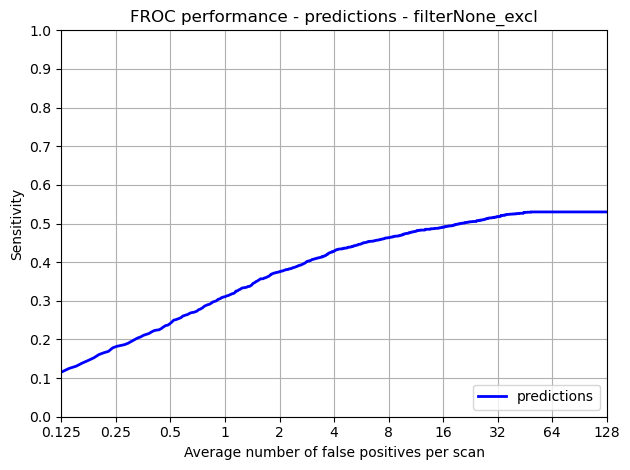

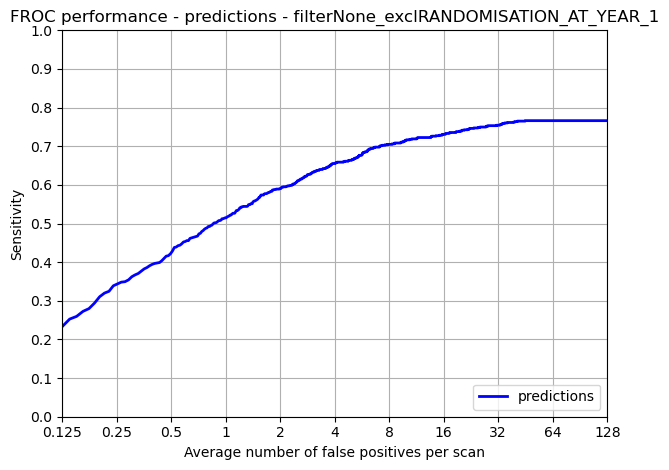

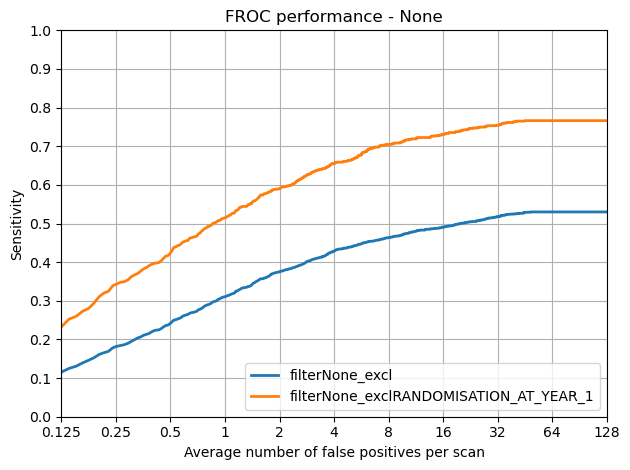

In [8]:

# Get the metadata that will be used across the all runs
config = {
    'model' : 'grt123',
    'run_name' : 'all',
    'training_data' : 'trained_summit',
    'phase' : 'validation'
}
scan_metadata, nodule_metadata, predictions = get_grt123_data(**config)
display_toplevel_metrics(scan_metadata, nodule_metadata, predictions, **config)

In [ ]:
display_granular_metrics(scan_metadata, nodule_metadata, predictions, filters)

# Detection Evaluation

## Trained on LUNA16 Evaluated on SUMMIT 

In [ ]:

config = {
    'model' : 'detect',
    'run_name' : 'all',
    'training_data' : 'trained_luna',
    'phase' : 'validation'
}

scan_metadata, nodule_metadata, predictions = get_detect_data(**config)
display_toplevel_metrics(scan_metadata, nodule_metadata, predictions, **config)

## Trained on SUMMIT Evaluated on SUMMIT

In [ ]:
config = {
    'model' : 'detect',
    'run_name' : 'all',
    'training_data' : 'trained_luna',
    'phase' : 'validation'
}
scan_metadata, nodule_metadata, predictions = get_detect_data(**config)
display_toplevel_metrics(scan_metadata, nodule_metadata, predictions, **config)

In [ ]:
display_granular_metrics(scan_metadata, nodule_metadata, predictions, filters, **config)

# Ensemble of two models

Combine predictions from the models

1. Have 0.5 overlap as per evaluation script
2. Diameter must be >.75 the same otherwise assume a different nodule reference

In [ ]:
from numpy import mean


def is_same_nodule(irc_1, d_1, irc_2, d_2):

    if (d_1 - d_2) / max(d_1,d_2) > 0.25:
        return False
    
    coords11 = np.array(irc_1) - d_1
    coords12 = np.array(irc_1) + d_1

    coords21 = np.array(irc_2) - d_2
    coords22 = np.array(irc_2) + d_2

    overlap = np.prod(np.minimum(coords12,coords22) - np.maximum(coords11,coords21))
    
    if overlap/(min(d_1,d_2)**3) > 0.5:
        return np.mean([np.array(irc_1), np.array(irc_2)],axis=0), np.mean([d_1, d_2])
    
    
is_same_nodule((5,5,5),4,(6,6,6),4)
